# Perceptron with PyTorch

A typical roadmap of designing machine learning systems consists of the following steps:
1. Preprocessing I:
    - Data collection
    - Data cleaning
    - Data transformation and normalization
    - Dealing with missing data
    - Feature extraction and selection
    - Splitting the data into training, testing and validation sets
    
2. Preprocessing II:
    - Feature scaling, selection, extraction
    - Choosing a model
    - Training the model
    - Evaluating the model
    - Hyperparameter tuning
    - Evaluate and iterate the process
    

### The following code is an implementation of a simple perceptron in PyTorch with an object-oriented approach.

In [43]:
import numpy as np
class Perceptron:
    """
    Perceptron classifier.
    """
    def __init__(self, learning_rate=0.01, iterations=100, random_state=1):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.random_state = random_state
        
    def fit(self, X, y):
        """
        Fit the training data.
        :param X: training data, shape = [n_examples, n_features]
        :param y: target values, shape = [n_examples]
        :return: self
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        print(f"Weight initializations: {self.w_}")
        self.b_ = np.float_(0.)
        print(f"Bias initializations: {self.b_}")
        self.errors_ = []
        
        for _ in range(self.iterations):
            errors = 0
            for xi, target in zip(X, y):
                update = self.learning_rate * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
        
    def net_input(self, X):
        """Calculate dot product"""
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        """Return class label after unit step"""
        dot_product = self.net_input(X) >= 0.0
        return np.where(dot_product, 1, 0)
    

### Test the perceptron with the Iris dataset

In [44]:
import pandas as pd
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail(10)

,0,1,2,3,4
140,6.7,3.1,5.6,2.4,Iris-virginica
141,6.9,3.1,5.1,2.3,Iris-virginica
142,5.8,2.7,5.1,1.9,Iris-virginica
143,6.8,3.2,5.9,2.3,Iris-virginica
144,6.7,3.3,5.7,2.5,Iris-virginica
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Shape of X: (100, 2)
Shape of y: (100,)


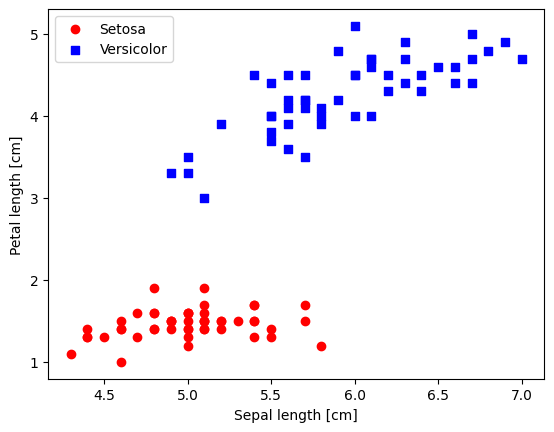

In [45]:
import matplotlib.pyplot as plt

y = df.iloc[0:100, 4].values
y = np.where(y == "Iris-setosa", 0, 1)

X = df.iloc[0:100, [0, 2]].values
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

plt.scatter(X[:50, 0], X[:50, 1], color="red", marker="o", label="Setosa")
plt.scatter(X[50:100, 0], X[50:100, 1], color="blue", marker="s", label="Versicolor")
plt.xlabel("Sepal length [cm]")
plt.ylabel("Petal length [cm]")
plt.legend(loc="upper left")
plt.show()

Weight initializations: [ 0.01624345 -0.00611756]
Bias initializations: 0.0


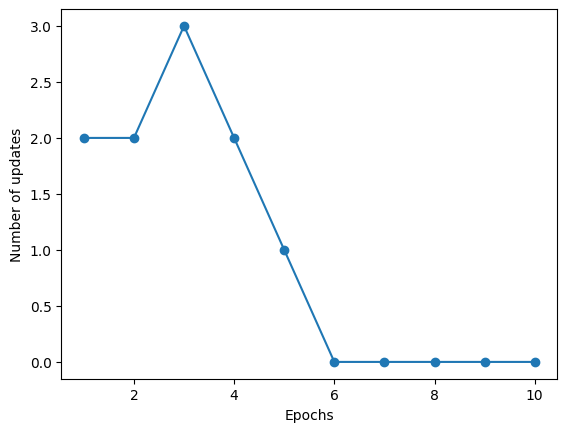

In [46]:
ppn = Perceptron(learning_rate=0.1, iterations=10)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Number of updates")
plt.show()

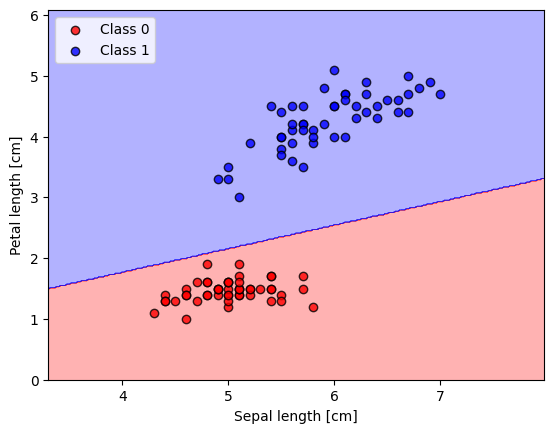

In [47]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    label=f"Class {cl}",
                    edgecolor="black")
        
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel("Sepal length [cm]")
plt.ylabel("Petal length [cm]")
plt.legend(loc="upper left")
plt.show()

# Adaline Perceptron with Stochastic Gradient Descent

In [48]:
class AdalineSGD:
    """
    Perceptron (Adaline version with identity activation function) implemented with SGD
    """
    def __init__(self, learning_rate=0.1, iterations=10, shuffle=True, random_state=None):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.iterations):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self
    
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights (online learning)"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffles the training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update weights"""
        output = self.activation(self.net_input(xi))
        error = target - output
        self.w_ += self.learning_rate * 2.0 * xi * error
        self.b_ += self.learning_rate * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

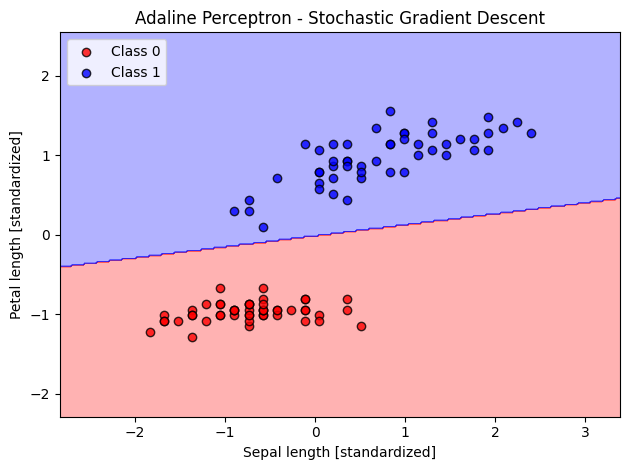

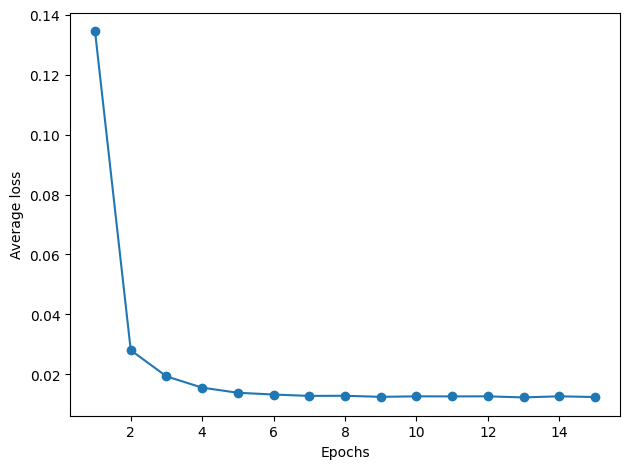

In [49]:
# Standardize data
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

sgd = AdalineSGD(learning_rate=0.01, iterations=15, random_state=1)
sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=sgd)
plt.title("Adaline Perceptron - Stochastic Gradient Descent")
plt.xlabel("Sepal length [standardized]")
plt.ylabel("Petal length [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
plt.plot(range(1, len(sgd.losses_) + 1), sgd.losses_, marker="o")
plt.xlabel("Epochs")
plt.ylabel("Average loss")
plt.tight_layout()
plt.show()